In [162]:
from __future__ import print_function, division
import os
import argparse
import torch.nn as nn
from skimage import io
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
from utils import *
from utils.KittiColormap import *
from pyntcloud import PyntCloud
import pandas as pd
from cv_bridge import CvBridge
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
from datasets.data_io import get_transform, read_all_lines
from PIL import Image
import open3d as o3d

## Load Data from rosbag

In [163]:
list_filename = "./filenames/DS_test.txt"
lines = read_all_lines(list_filename)
splits = [line.split() for line in lines]
left_filenames = [x[0] for x in splits]
right_filenames = [x[1] for x in splits]
disp_filenames = [x[2] for x in splits]

In [164]:
def load_image(filename):
    return Image.open(filename).convert('RGB')

def load_disp(filename):
    data = Image.open(filename)
    data = np.array(data, dtype=np.float32) / 256.
    return data

In [165]:
def display_image_in_actual_size(im_data, save_path):
    dpi = 75
    height, width = im_data.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='plasma')
    plt.savefig(save_path)
    plt.show()

In [166]:
data_index = 11
datapath = "/home/chris/pl_ws/src/stereo_pl_nav/datasets/DS"
left_img = load_image(os.path.join(datapath, left_filenames[data_index]))
right_img = load_image(os.path.join(datapath, right_filenames[data_index]))
disparity = load_disp(os.path.join(datapath, disp_filenames[data_index]))

(400, 881, 3)


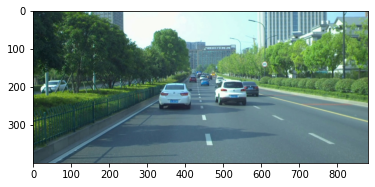

In [167]:
plt.imshow(left_img)
left_img.save(f"/home/chris/Desktop/voxelnet-images/left-{data_index}.png", format="png")
left_frame = np.asarray(left_img)
left_depth_rgb = left_frame[:, :, :3]
print(np.asarray(left_img).shape)

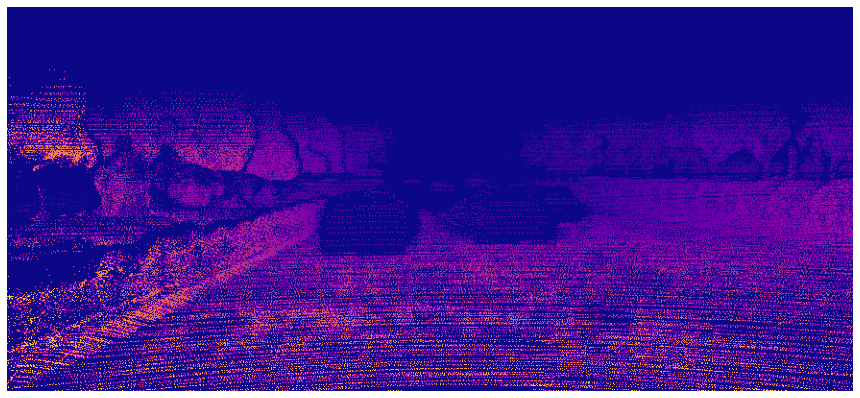

(400, 881)


In [168]:
display_image_in_actual_size(disparity, f"/home/chris/Desktop/voxelnet-images/disp-{data_index}.png")
print(disparity.shape)

In [169]:
w, h = left_img.size
crop_w, crop_h = 880, 400

left_img = left_img.crop((w - crop_w, h - crop_h, w, h))
right_img = right_img.crop((w - crop_w, h - crop_h, w, h))
print(disparity.shape)
disparity = disparity[h - crop_h:h, w - crop_w: w]

depth_rgb = np.transpose(np.asarray(left_img)[:, :, :3], (2, 0, 1))
print(depth_rgb.shape)

processed = get_transform()
left_img = processed(left_img)
right_img = processed(right_img)

(400, 881)
(3, 400, 880)


In [170]:
left_img.shape

torch.Size([3, 400, 880])

(400, 880)

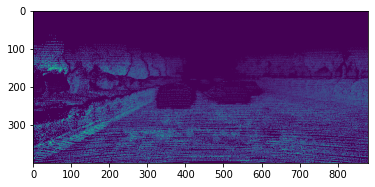

In [171]:
plt.imshow(disparity)
disparity.shape

In [172]:
# Camera intrinsics and extrinsics
c_u = 4.556890e+2
c_v = 1.976634e+2
f_u = 1.003556e+3
f_v = 1.003556e+3
b_x = 0.0
b_y = 0.0
baseline = 0.54

In [173]:
def project_image_to_rect(uv_depth):
    ''' Input: nx3 first two channels are uv, 3rd channel
               is depth in rect camera coord.
        Output: nx3 points in rect camera coord.
    '''
    n = uv_depth.shape[0]
    x = ((uv_depth[:, 0] - c_u) * uv_depth[:, 2]) / f_u + b_x
    y = ((uv_depth[:, 1] - c_v) * uv_depth[:, 2]) / f_v + b_y
    pts_3d_rect = np.zeros((n, 3))
    pts_3d_rect[:, 0] = x
    pts_3d_rect[:, 1] = y
    pts_3d_rect[:, 2] = uv_depth[:, 2]
    return pts_3d_rect

def project_image_to_velo(uv_depth):
    pts_3d_rect = project_image_to_rect(uv_depth)
    return pts_3d_rect

# mobilestereonet

In [174]:
from models.mobilestereonet.models.MSNet2D import MSNet2D
model = MSNet2D(192)
model = nn.DataParallel(model)
model.cuda()

DataParallel(
  (module): MSNet2D(
    (feature_extraction): feature_extraction(
      (firstconv): Sequential(
        (0): MobileV2_Residual(
          (conv): Sequential(
            (0): Conv2d(3, 9, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
            (3): Conv2d(9, 9, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=9, bias=False)
            (4): BatchNorm2d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (5): ReLU6(inplace=True)
            (6): Conv2d(9, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (1): ReLU(inplace=True)
        (2): MobileV2_Residual(
          (conv): Sequential(
            (0): Conv2d(32, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          

In [175]:
ckpt_path = "/home/chris/pl_ws/src/stereo_pl_nav/scripts/models/MSNet2D_SF_DS_KITTI2015.ckpt"
print("Loading model {}".format(ckpt_path))
state_dict = torch.load(ckpt_path)
model.load_state_dict(state_dict['model'])

Loading model /home/chris/pl_ws/src/stereo_pl_nav/scripts/models/MSNet2D_SF_DS_KITTI2015.ckpt


<All keys matched successfully>

WARNING - 2022-05-24 15:29:25,077 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


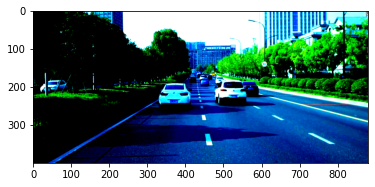

WARNING - 2022-05-24 15:29:25,156 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


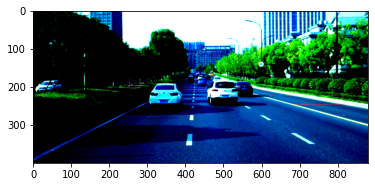

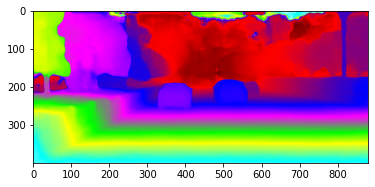

In [176]:
import matplotlib.pyplot as plt

model.eval()
plt.imshow(np.transpose(left_img, (1,2,0)))
plt.show()
plt.imshow(np.transpose(right_img, (1,2,0)))
plt.show()

sample_left = torch.Tensor(left_img)
sample_right = torch.Tensor(right_img)

sample_left = torch.unsqueeze(sample_left, dim=0)
sample_right = torch.unsqueeze(sample_right, dim=0)

with torch.no_grad():
    disp_est_tn = model(sample_left.cuda(), sample_right.cuda())[0]
    disp_est_np = tensor2numpy(disp_est_tn)
    disp_est = np.array(disp_est_np[0], dtype=np.float32)
    plt.imshow(kitti_colormap(disp_est))
    plt.show()
    disp_est[disp_est < 0] = 0

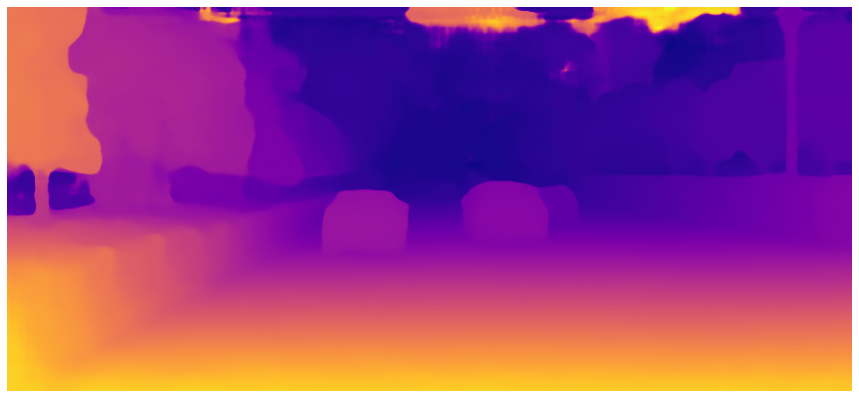

In [177]:
display_image_in_actual_size(disp_est, f"/home/chris/Desktop/voxelnet-images/mobile-{data_index}.png")

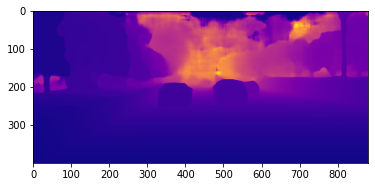

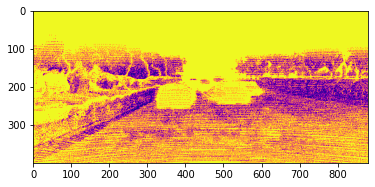

In [178]:
mask = disp_est > 0
depth = f_u * baseline / (disp_est + 1. - mask)
plt.imshow(depth, cmap="plasma")
plt.show()

mask = disparity > 0
depth_gt = f_u * baseline / (disparity + 1. - mask)
plt.imshow(depth_gt, cmap="plasma")
plt.show()

In [179]:
mask = disp_est > 0
rows, cols = depth.shape
c, r = np.meshgrid(np.arange(cols), np.arange(rows))
points = np.stack([c, r, depth])
points = points.reshape((3, -1))
points = points.T
points = points[mask.reshape(-1)]
cloud = project_image_to_velo(points)

mask = disparity > 0
rows, cols = depth_gt.shape
c, r = np.meshgrid(np.arange(cols), np.arange(rows))
points = np.stack([c, r, depth_gt])
points = points.reshape((3, -1))
points = points.T
points = points[mask.reshape(-1)]
cloud_gt = project_image_to_velo(points)


points_rgb = depth_rgb.reshape((3, -1)).T
points_rgb = points_rgb.astype(float)
points_rgb /= 255.

In [180]:
cloud_gt.shape

(75822, 3)

In [181]:
cloud.shape

(352000, 3)

In [182]:
points_rgb.shape

(352000, 3)

In [183]:
# Pass xyz to Open3D.o3d.geometry.PointCloud and visualize
rgbd_pcd = o3d.geometry.PointCloud()
rgbd_pcd.points = o3d.utility.Vector3dVector(cloud)
rgbd_pcd.colors = o3d.utility.Vector3dVector(points_rgb)

gt_pcd = o3d.geometry.PointCloud()
gt_pcd.points = o3d.utility.Vector3dVector(cloud_gt)

o3d.visualization.draw_geometries([rgbd_pcd,gt_pcd],
                                 front=[ 0.060748975810558881, 0.058005491788925577, -0.99646621862474261 ],
                                 lookat=[ -4.0462762398004077, -4.4849709120948287, 71.46948359545145 ],
                                 up=[ 0.017934660713112491, -0.99821229179131388, -0.057013756777106635 ],
                                 zoom=0.32000000000000001)

# Filter GT to voxel grid

In [184]:
voxel_size = 0.5
min_mask = cloud_gt >= [-16,-31,0.0]
max_mask = cloud_gt <= [16,1,32]
min_mask = min_mask[:, 0] & min_mask[:, 1] & min_mask[:, 2]
max_mask = max_mask[:, 0] & max_mask[:, 1] & max_mask[:, 2]
filter_mask = min_mask & max_mask
filtered_cloud = cloud_gt[filter_mask]

xyz_q = np.floor(np.array(filtered_cloud/voxel_size)).astype(int) # quantized point values, here you will loose precision
vox_grid = np.zeros((int(32/voxel_size), int(32/voxel_size), int(32/voxel_size))) #Empty voxel grid
offsets = np.array([32, 62, 0])
xyz_offset_q = xyz_q+offsets
vox_grid[xyz_offset_q[:,0],xyz_offset_q[:,1],xyz_offset_q[:,2]] = 1 # Setting all voxels containitn a points equal to 1

xyz_v = np.asarray(np.where(vox_grid == 1)) # get back indexes of populated voxels
cloud_np = np.asarray([(pt-offsets)*voxel_size for pt in xyz_v.T])

gt_vox_pcd = o3d.geometry.PointCloud()
gt_vox_pcd.points = o3d.utility.Vector3dVector(cloud_np)
gt_vox_pcd.colors = o3d.utility.Vector3dVector(np.random.uniform(0, 1, size=(len(cloud_np), 3)))
    
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(gt_vox_pcd,
                                                          voxel_size=0.5)    

o3d.visualization.draw_geometries([rgbd_pcd,voxel_grid],
                                 front=[ 0.060748975810558881, 0.058005491788925577, -0.99646621862474261 ],
                                 lookat=[ -4.0462762398004077, -4.4849709120948287, 71.46948359545145 ],
                                 up=[ 0.017934660713112491, -0.99821229179131388, -0.057013756777106635 ],
                                 zoom=0.32000000000000001)

# coex

In [141]:
from models.coex.stereo import Stereo
from ruamel.yaml import YAML
def load_configs(path):
    cfg = YAML().load(open(path, 'r'))
    backbone_cfg = YAML().load(
        open(cfg['model']['stereo']['backbone']['cfg_path'], 'r'))
    cfg['model']['stereo']['backbone'].update(backbone_cfg)
    return cfg

config = 'cfg_coex.yaml'
version = 0  # CoEx

cfg = load_configs(
    './models/coex/configs/stereo/{}'.format(config))

ckpt = '{}/{}/version_{}/checkpoints/last.ckpt'.format(
    './models/coex/logs/stereo', cfg['model']['name'], version)
cfg['stereo_ckpt'] = ckpt
# load model
model = Stereo.load_from_checkpoint(cfg['stereo_ckpt'],
                                            strict=False,
                                            cfg=cfg).cuda()

INFO - 2022-05-24 15:27:47,200 - helpers - Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/mobilenetv2_100_ra-b33bc2c4.pth)


WARNING - 2022-05-24 15:27:47,658 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


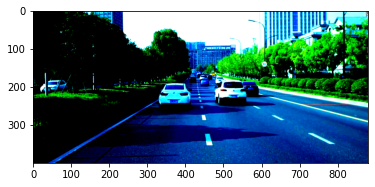

WARNING - 2022-05-24 15:27:47,856 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


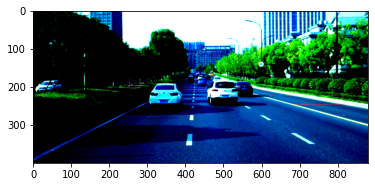

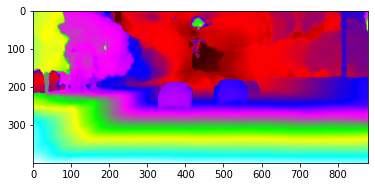

In [142]:
model.eval()
plt.imshow(np.transpose(left_img, (1,2,0)))
plt.show()
plt.imshow(np.transpose(right_img, (1,2,0)))
plt.show()

sample_left = torch.Tensor(left_img)
sample_right = torch.Tensor(right_img)

sample_left = torch.unsqueeze(sample_left, dim=0)
sample_right = torch.unsqueeze(sample_right, dim=0)

with torch.no_grad():
    disp_est_tn = model(sample_left.cuda(), sample_right.cuda())[0]
    disp_est_np = tensor2numpy(disp_est_tn)
    disp_est = np.array(disp_est_np, dtype=np.float32)
    plt.imshow(kitti_colormap(disp_est))
    plt.show()
    disp_est[disp_est < 0] = 0

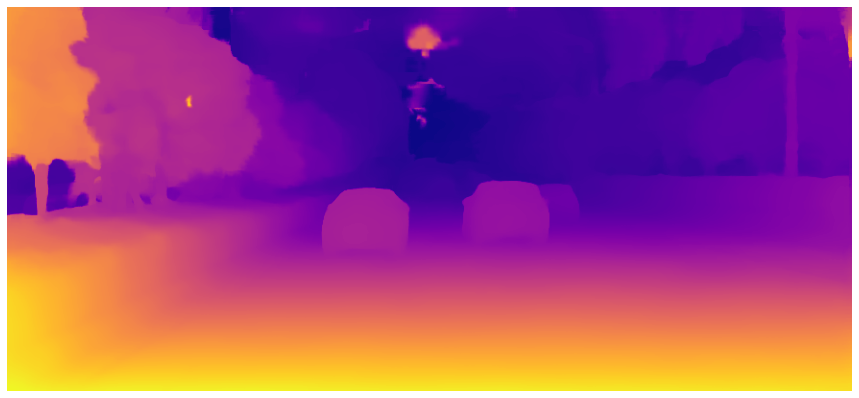

In [143]:
display_image_in_actual_size(disp_est, f"/home/chris/Desktop/voxelnet-images/coex-{data_index}.png")

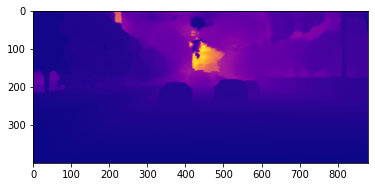

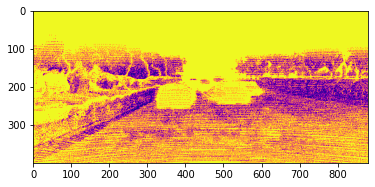

In [144]:
mask = disp_est > 0
depth = f_u * baseline / (disp_est + 1. - mask)
plt.imshow(depth, cmap="plasma")
plt.show()

mask = disparity > 0
depth_gt = f_u * baseline / (disparity + 1. - mask)
plt.imshow(depth_gt, cmap="plasma")
plt.show()

In [145]:
mask = disp_est > 0
rows, cols = depth.shape
c, r = np.meshgrid(np.arange(cols), np.arange(rows))
points = np.stack([c, r, depth])
points = points.reshape((3, -1))
points = points.T
points = points[mask.reshape(-1)]
cloud = project_image_to_velo(points)

mask = disparity > 0
rows, cols = depth_gt.shape
c, r = np.meshgrid(np.arange(cols), np.arange(rows))
points = np.stack([c, r, depth_gt])
points = points.reshape((3, -1))
points = points.T
points = points[mask.reshape(-1)]
cloud_gt = project_image_to_velo(points)


points_rgb = depth_rgb.reshape((3, -1)).T
points_rgb = points_rgb.astype(float)
points_rgb /= 255.

In [148]:
voxel_size = 0.5
min_mask = cloud >= [-16,-31,0.0]
max_mask = cloud <= [16,1,32]
min_mask = min_mask[:, 0] & min_mask[:, 1] & min_mask[:, 2]
max_mask = max_mask[:, 0] & max_mask[:, 1] & max_mask[:, 2]
filter_mask = min_mask & max_mask
filtered_cloud = cloud[filter_mask]

xyz_q = np.floor(np.array(filtered_cloud/voxel_size)).astype(int) # quantized point values, here you will loose precision
vox_grid = np.zeros((int(32/voxel_size), int(32/voxel_size), int(32/voxel_size))) #Empty voxel grid
offsets = np.array([32, 62, 0])
xyz_offset_q = xyz_q+offsets
vox_grid[xyz_offset_q[:,0],xyz_offset_q[:,1],xyz_offset_q[:,2]] = 1 # Setting all voxels containitn a points equal to 1

xyz_v = np.asarray(np.where(vox_grid == 1)) # get back indexes of populated voxels
cloud_np = np.asarray([(pt-offsets)*voxel_size for pt in xyz_v.T])


vox_pcd = o3d.geometry.PointCloud()
vox_pcd.points = o3d.utility.Vector3dVector(cloud_np)
vox_pcd.colors = o3d.utility.Vector3dVector(np.random.uniform(0, 1, size=(len(cloud_np), 3)))
    
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(vox_pcd,
                                                          voxel_size=0.5)    

o3d.visualization.draw_geometries([rgbd_pcd,voxel_grid],
                                 front=[ 0.060748975810558881, 0.058005491788925577, -0.99646621862474261 ],
                                 lookat=[ -4.0462762398004077, -4.4849709120948287, 71.46948359545145 ],
                                 up=[ 0.017934660713112491, -0.99821229179131388, -0.057013756777106635 ],
                                 zoom=0.32000000000000001)

# SGBM

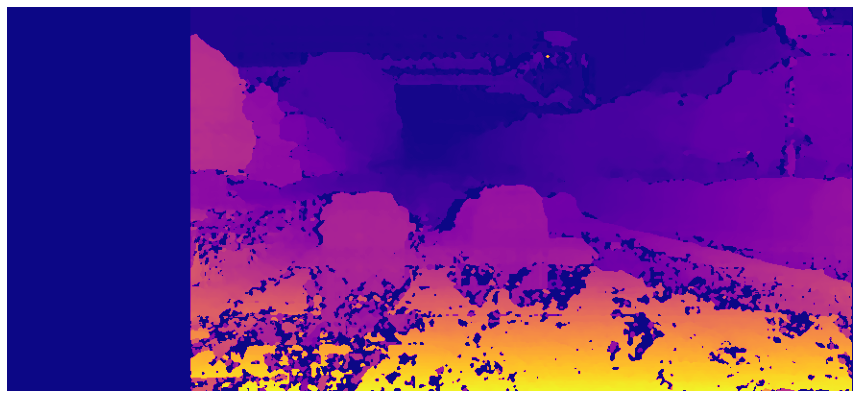

In [149]:
#Note: disparity range is tuned according to specific parameters obtained through trial and error. 
win_size = 5
min_disp = -1
max_disp = 191 #min_disp * 9
num_disp = max_disp - min_disp # Needs to be divisible by 16
#Create Block matching object. 
sgbm = cv2.StereoSGBM_create(minDisparity= min_disp,
numDisparities = num_disp,
blockSize = 5,
uniquenessRatio = 5,
speckleWindowSize = 5,
speckleRange = 5,
disp12MaxDiff = 1,
P1 = 8*3*win_size**2,#8*3*win_size**2,
P2 =32*3*win_size**2) #32*3*win_size**2)
left_img = load_image(os.path.join(datapath, left_filenames[data_index]))
right_img = load_image(os.path.join(datapath, right_filenames[data_index]))
sgbm_disparity = sgbm.compute(cv2.cvtColor(np.asarray(left_img), cv2.COLOR_BGR2GRAY),cv2.cvtColor(np.asarray(right_img), cv2.COLOR_BGR2GRAY))
sgbm_disparity[sgbm_disparity < 0] = 0
sgbm_disparity = sgbm_disparity/3040*192.
display_image_in_actual_size(sgbm_disparity, f"/home/chris/Desktop/voxelnet-images/sgbm-{data_index}.png")

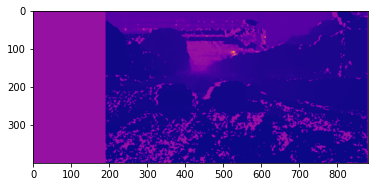

In [150]:
disp_est = sgbm_disparity
mask = disp_est > 0
depth = f_u * baseline / (disp_est + 1. - mask)
plt.imshow(depth, cmap="plasma")
plt.show()

In [151]:
mask = disp_est > 0
rows, cols = depth.shape
c, r = np.meshgrid(np.arange(cols), np.arange(rows))
points = np.stack([c, r, depth])
points = points.reshape((3, -1))
points = points.T
points = points[mask.reshape(-1)]
cloud = project_image_to_velo(points)

mask = disparity > 0
rows, cols = depth_gt.shape
c, r = np.meshgrid(np.arange(cols), np.arange(rows))
points = np.stack([c, r, depth_gt])
points = points.reshape((3, -1))
points = points.T
points = points[mask.reshape(-1)]
cloud_gt = project_image_to_velo(points)


points_rgb = depth_rgb.reshape((3, -1)).T
points_rgb = points_rgb.astype(float)
points_rgb /= 255.

In [192]:
voxel_size = 0.5
min_mask = cloud >= [-16,-31,0.0]
max_mask = cloud <= [16,1,32]
min_mask = min_mask[:, 0] & min_mask[:, 1] & min_mask[:, 2]
max_mask = max_mask[:, 0] & max_mask[:, 1] & max_mask[:, 2]
filter_mask = min_mask & max_mask
filtered_cloud = cloud[filter_mask]

xyz_q = np.floor(np.array(filtered_cloud/voxel_size)).astype(int) # quantized point values, here you will loose precision
vox_grid = np.zeros((int(32/voxel_size), int(32/voxel_size), int(32/voxel_size))) #Empty voxel grid
offsets = np.array([32, 62, 0])
xyz_offset_q = xyz_q+offsets
vox_grid[xyz_offset_q[:,0],xyz_offset_q[:,1],xyz_offset_q[:,2]] = 1 # Setting all voxels containitn a points equal to 1

xyz_v = np.asarray(np.where(vox_grid == 1)) # get back indexes of populated voxels
cloud_np = np.asarray([(pt-offsets)*voxel_size for pt in xyz_v.T])

vox_pcd = o3d.geometry.PointCloud()
vox_pcd.points = o3d.utility.Vector3dVector(cloud_np)
vox_pcd.colors = o3d.utility.Vector3dVector(np.random.uniform(0, 1, size=(len(cloud_np), 3)))
    
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(vox_pcd,
                                                          voxel_size=0.5)    

o3d.visualization.draw_geometries([rgbd_pcd,voxel_grid],
                                 front=[ 0.060748975810558881, 0.058005491788925577, -0.99646621862474261 ],
                                 lookat=[ -4.0462762398004077, -4.4849709120948287, 71.46948359545145 ],
                                 up=[ 0.017934660713112491, -0.99821229179131388, -0.057013756777106635 ],
                                 zoom=0.32000000000000001)

# Load VoxelNavNet

In [153]:
from models.Voxel2D import Voxel2D
voxel_model = Voxel2D(192, "voxel")
voxel_model = nn.DataParallel(voxel_model)
voxel_model.cuda()

DataParallel(
  (module): Voxel2D(
    (feature_extraction): feature_extraction(
      (firstconv): Sequential(
        (0): MobileV2_Residual(
          (conv): Sequential(
            (0): Conv2d(3, 9, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
            (3): Conv2d(9, 9, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=9, bias=False)
            (4): BatchNorm2d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (5): ReLU6(inplace=True)
            (6): Conv2d(9, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (1): ReLU(inplace=True)
        (2): MobileV2_Residual(
          (conv): Sequential(
            (0): Conv2d(32, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          

In [154]:
ckpt_path = "/home/chris/pl_ws/src/stereo_pl_nav/scripts/voxelstereonet/logs/lr_0.001_batch_size_16_cost_vol_type_voxel_optimizer_adam_/best.ckpt"
voxel_model.load_state_dict(torch.load(ckpt_path)['model'])

<All keys matched successfully>

In [185]:
# calculate voxel cost volume disparity set
vox_cost_vol_disp_set = set()
max_disp = 192
# depth starting from voxel_size since 0 will cause issue
for z in np.arange(0.5, 32, 0.5*4):
    # get respective disparity
    d = f_u * baseline / z

    if d > max_disp:
        continue

    # real disparity -> disparity in feature map
    vox_cost_vol_disp_set.add(round(d/4))

vox_cost_vol_disps = list(vox_cost_vol_disp_set)
vox_cost_vol_disps = sorted(vox_cost_vol_disps)

tmp = []
for i in vox_cost_vol_disps:
    tmp.append(torch.unsqueeze(torch.Tensor([i]), 0))
vox_cost_vol_disps = tmp

In [186]:
vox_cost_vol_disps

[tensor([[4.]]),
 tensor([[5.]]),
 tensor([[6.]]),
 tensor([[7.]]),
 tensor([[8.]]),
 tensor([[9.]]),
 tensor([[11.]]),
 tensor([[13.]]),
 tensor([[16.]]),
 tensor([[21.]]),
 tensor([[30.]])]

In [187]:
def get_model_pred(model, sample_left, sample_right, voxel_disp):
    with torch.no_grad():
        return model(sample_left.cuda(), sample_right.cuda(), voxel_disp)[0][0]

In [188]:
voxel_pred = get_model_pred(voxel_model, sample_left, sample_right, vox_cost_vol_disps)

In [189]:
def get_visualize(vox_pred, color=[1.0, 0.0, 0.0]):
    vox_pred = vox_pred.detach().cpu().numpy()
    vox_pred[vox_pred < 0.5] = 0
    vox_pred[vox_pred >= 0.5] = 1
    
    offsets = np.array([32, 62, 0])
    voxel_size = 0.5
    xyz_pred = np.asarray(np.where(vox_pred == 1)) # get back indexes of populated voxels
    cloud_pred = np.asarray([(pt-offsets)*voxel_size for pt in xyz_pred.T])
    
    pred_pcd = o3d.geometry.PointCloud()
    pred_pcd.points = o3d.utility.Vector3dVector(cloud_pred)
#     pred_pcd.paint_uniform_color(color)
    pred_pcd.colors = o3d.utility.Vector3dVector(np.random.uniform(0, 1, size=(len(cloud_pred), 3)))
    
    voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pred_pcd,
                                                              voxel_size=0.5)    
    return voxel_grid

In [190]:
# Pass xyz to Open3D.o3d.geometry.PointCloud and visualize
rgbd_pcd = o3d.geometry.PointCloud()
rgbd_pcd.points = o3d.utility.Vector3dVector(cloud)
rgbd_pcd.colors = o3d.utility.Vector3dVector(points_rgb)

o3d.visualization.draw_geometries([rgbd_pcd, get_visualize(voxel_pred, color=[1.0, 0.0, 0.0])],
                                 front=[ 0.060748975810558881, 0.058005491788925577, -0.99646621862474261 ],
                                 lookat=[ -4.0462762398004077, -4.4849709120948287, 71.46948359545145 ],
                                 up=[ 0.017934660713112491, -0.99821229179131388, -0.057013756777106635 ],
                                 zoom=0.32000000000000001)

In [ ]:
unit_np_pcd = o3d.geometry.PointCloud()
unit_np_pcd.points = o3d.utility.Vector3dVector(np.array([[0.0, -2.0, 0.0],[0.0, 0.0, 0.0],[0.0, 4.0, 0.0]]))
unit_np_pcd.paint_uniform_color([0.0, 0.0, 1.0])
o3d.visualization.draw_geometries([rgbd_pcd, unit_np_pcd])